In [792]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import sklearn
import optuna
from plotly.subplots import make_subplots
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [798]:
# read in files
holiday_df = pd.read_csv("holidays_events.csv")
oil_df = pd.read_csv("oil.csv")
store_df = pd.read_csv('stores.csv')
train_df = pd.read_csv('train.csv', dtype = {'store_nbr': 'category'})
test_df = pd.read_csv("test.csv", dtype = {'store_nbr': 'category'})

# EDA

In [676]:
# overall sales trend
daily_sales_df = train_df[['date', 'sales']].groupby('date').mean().reset_index()
fig = go.Figure(data=go.Scatter(x=daily_sales_df['date'], 
                                y=daily_sales_df['sales'],
                                marker_color='red', text="sales"))
fig.show()

In [ ]:
# extract date features
train_df['year'] = pd.to_datetime(train_df['date']).dt.year
train_df['month'] = pd.to_datetime(train_df['date']).dt.month
train_df['day'] = pd.to_datetime(train_df['date']).dt.day
train_df['day_of_week'] = pd.to_datetime(train_df['date']).dt.day_name()

# sales by month
by_month_df = train_df.groupby(['month'])['sales'].mean().reset_index()
fig = px.bar(by_month_df, x='month', y='sales', color='sales', color_continuous_scale="darkmint")
fig.show()

In [ ]:
# sales by day of month
by_day_df = train_df.groupby(['day'])['sales'].mean().reset_index()
fig = go.Figure(data=go.Scatter(x=by_day_df['day'], 
                                y=by_day_df['sales'],
                                marker_color='red', text="sales"))
fig.show()

In [ ]:
# sales by day of week
by_weekday_df = train_df.groupby(['day_of_week'])['sales'].mean()
new_order_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
by_weekday_df = by_weekday_df.reindex(new_order_week, axis=0).reset_index()
fig = px.bar(by_weekday_df, x='day_of_week', y='sales', color='sales', color_continuous_scale="darkmint")
fig.show()

In [ ]:
# holiday sales
holiday_sales_df = pd.merge(daily_sales_df, holiday_df, on='date', how='inner')
fig = px.scatter(holiday_sales_df, x='date', y='sales', size='sales', color='type')
fig.show()

In [721]:
train_df.groupby('date')

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [723]:
# school and office supply sales trend
# This is the family that needs special attention
school_sales_df = train_df[train_df['family'] == 'SCHOOL AND OFFICE SUPPLIES']
daily_school_sales_df = school_sales_df.groupby(['date'])['sales'].mean().reset_index()
fig = go.Figure(data=go.Scatter(x=daily_school_sales_df['date'], 
                                y=daily_school_sales_df['sales'],
                                marker_color='red', text="sales"))
fig.show()
# peaks appear in April, Augest, and Sept

In [ ]:
# store
store_sales_df = pd.merge(train_df, store_df, on='store_nbr', how='inner')
city_sales_df = store_sales_df.groupby(['city'])['sales'].mean().reset_index()
fig = px.bar(city_sales_df, x='city', y='sales', color = 'sales', color_continuous_scale="blues")
fig.show()

In [ ]:
# oil_price trend
fig = go.Figure(data=go.Scatter(x=oil_df['date'], 
                                y=oil_df['dcoilwtico'],
                                marker_color='red', text="sales"))
fig.show()

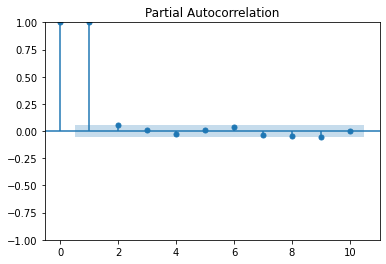

In [788]:
# autocorrelation of oil price
tmp_oil_df = oil_df.fillna(method = 'ffill')
_ = plot_pacf(tmp_oil_df[1:]['dcoilwtico'], lags = 10)

# Feature Engineering

In [799]:
# only keep national holiday for simplicity
holiday_df = holiday_df[holiday_df['locale'] == 'National']
holiday_df.drop(columns = ['locale', 'locale_name'], inplace = True)
# drop duplicated holiday, leave the holiday with higher avg sales, which means more important holiday
tmp_df = pd.merge(holiday_df, train_df.groupby('date')['sales'].mean().reset_index(), on = 'date', how = 'left')
holiday_df = tmp_df.sort_values('sales').drop_duplicates(['date'], keep = 'last').drop(columns = ['sales', 'description'])
holiday_df.rename(columns = {'type': 'holiday_type'}, inplace = True)
# set date as index
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df.set_index(['date'], inplace = True) 

In [800]:
# preprocess oil data
oil_df.rename(columns = {'dcoilwtico': 'oil_price'}, inplace = True)
# last 7 day avg price
oil_df['last7d_oil_price'] = oil_df['oil_price'].rolling(7).mean()
# fill null with previous day oil price
oil_df = pd.DataFrame({'date': pd.date_range('2013-01-01', '2017-08-31').astype(str)}).merge(oil_df, on = 'date', how = 'left')
oil_df.fillna(method = 'ffill', inplace = True)
# lag price
for lag in range(1, 4):
    oil_df[f'oil_price_lag{lag}'] = oil_df['oil_price'].shift(lag)
    oil_df[f'oil_price_lag{lag}'].fillna(oil_df['oil_price'], inplace = True)
# set date as index
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df.set_index(['date'], inplace = True) 

In [801]:
# fourier features
fourier = CalendarFourier(freq='W', order=4)

dp = DeterministicProcess(index=pd.date_range('2017-04-01', '2017-08-31'),
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
dp_df = dp.in_sample()
for i in range(1,4):
    dp_df.rename(columns = {f'sin({i},freq=W-SUN)': f'sin{i}'}, inplace = True)
    dp_df.rename(columns = {f'cos({i},freq=W-SUN)': f'cos{i}'}, inplace = True)

In [802]:
# merge all datasets
df = pd.DataFrame(index = pd.date_range('2017-04-01', '2017-08-31')) # training start from 2017-04-01
merged_df = df.merge(holiday_df, left_index = True, right_index = True, how = 'left')
merged_df = merged_df.merge(oil_df, left_index = True, right_index = True, how = 'left')
merged_df = merged_df.merge(dp_df, left_index = True, right_index = True, how = 'left')
merged_df['transferred'].fillna(False, inplace = True)

In [803]:
# date features
merged_df['month'] = pd.to_datetime(merged_df.index).month
merged_df['day'] = pd.to_datetime(merged_df.index).day
merged_df['day_of_week'] = pd.to_datetime(merged_df.index).day_name()
merged_df['is_school_day'] = (pd.to_datetime(merged_df.index).month.isin([3, 4, 8, 9])).astype(int)

In [804]:
# if is workday
merged_df['is_workday'] = 1
merged_df.loc[merged_df['day_of_week'].isin(['Saturday', 'Sunday']), 'is_workday'] = 0

merged_df.loc[merged_df['holiday_type'] == 'Bridge', 'is_workday'] = 0
merged_df.loc[merged_df['holiday_type'] == 'Work Day', 'is_workday'] = 1
merged_df.loc[merged_df['holiday_type'] == 'Transfer', 'is_workday'] = 0
merged_df.loc[(merged_df['holiday_type'] == 'Holiday') & (merged_df['transferred'] == False), 'is_workday'] = 0
merged_df.loc[(merged_df['holiday_type'] == 'Holiday') & (merged_df['transferred'] == True ), 'is_workday'] = 1
merged_df.drop(columns = ['transferred'], inplace = True)

merged_df = pd.get_dummies(merged_df, columns = ['holiday_type', 'day_of_week'])
merged_df.drop(columns = ['day_of_week_Monday'],inplace = True)

# Modelling

In [805]:
train_date = ['2017-04-01', '2017-07-31'] # training date range
valid_date = ['2017-08-01', '2017-08-15'] # validation date range
test_date = ['2017-08-16', '2017-08-31'] # test date range

In [806]:
# split train, validation, and test
X_train = merged_df[train_date[0]:train_date[1]]
X_valid = merged_df[valid_date[0]:valid_date[1]]
X_test = merged_df[test_date[0]:test_date[1]]
y = train_df[['store_nbr', 'family', 'date', 'sales']].set_index(['store_nbr', 'family', 'date']).sort_index().unstack(['store_nbr', 'family'])
y_train = y[train_date[0]:train_date[1]]
y_valid = y[valid_date[0]:valid_date[1]]

## Ridge + RF

In [807]:
# use random forest for 'school and office supplies' only, and use ridge regression for other families
class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':  
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs = -1)
            r2 = RandomForestRegressor(n_estimators = 225, n_jobs = -1)
            b1 = BaggingRegressor(base_estimator=r1, n_estimators = 10, n_jobs = -1)
            b2 = BaggingRegressor(base_estimator=r2, n_estimators = 10, n_jobs = -1)
            model = VotingRegressor([('et', b1), ('rf', b2)]) # Averaging the result 
        else:  
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)    
        model.fit(X, y)
        return model

    def fit(self, X, y):

        self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                              verbose=self.verbose,
                              )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        return
    
    def predict(self, X):
        
        y_pred = Parallel(n_jobs=self.n_jobs, 
                          verbose=self.verbose)(delayed(e.predict)(X) for e in self.estimators_)
        return np.stack(y_pred, axis=1)

In [808]:
# ridge + rf
model = CustomRegressor()
model.fit(X_train, y_train)
pred_df = pd.DataFrame(model.predict(X_valid),columns = y_train.columns, index = X_valid.index).stack(['store_nbr', 'family'])

In [809]:
# validation score
pred_df['sales'].clip(lower = 0, inplace = True)
pred_df['true_sales'] = y_valid.stack(['store_nbr', 'family']).values
print(mean_squared_log_error(pred_df['true_sales'], pred_df['sales']))
pred_df.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['true_sales']))

0.2916239058810894


family
AUTOMOTIVE                    0.308114
BABY CARE                     0.100612
BEAUTY                        0.384761
BEVERAGES                     0.070934
BOOKS                         0.019988
BREAD/BAKERY                  0.041758
CELEBRATION                   0.344112
CLEANING                      0.154260
DAIRY                         0.039586
DELI                          0.048173
EGGS                          0.110211
FROZEN FOODS                  0.087577
GROCERY I                     0.050237
GROCERY II                    0.456391
HARDWARE                      0.333958
HOME AND KITCHEN I            0.263666
HOME AND KITCHEN II           0.273673
HOME APPLIANCES               0.161031
HOME CARE                     0.091643
LADIESWEAR                    0.314233
LAWN AND GARDEN               0.238669
LINGERIE                      0.501379
LIQUOR,WINE,BEER              0.302535
MAGAZINES                     0.295259
MEATS                         0.054179
PERSONAL CARE     

## lgb

In [274]:
# rename
for i in range(1,4):
    X_train.rename(columns = {f'sin({i},freq=W-SUN)': f'sin{i}'}, inplace = True)
    X_train.rename(columns = {f'cos({i},freq=W-SUN)': f'cos{i}'}, inplace = True)

In [793]:
# optuna for parameter tunning
def objective(trial):
    param = {
        "objective": "multiclass",
        "metric": "binary_logloss",
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 100, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100),
        "max_depth": trial.suggest_int("max_depth", 20, 70),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    lgb_reg = MultiOutputRegressor(lgb.LGBMRegressor(**param))
    lgb_reg.fit(X_train, y_train)
    pred_df = pd.DataFrame(lgb_reg.predict(X_valid),columns = y_train.columns, index = X_valid.index).stack(['store_nbr', 'family'])
    pred_df['sales'].clip(lower = 0, inplace = True)
    pred_df['true_sales'] = y_valid.stack(['store_nbr', 'family']).values
    error = mean_squared_log_error(pred_df['true_sales'], pred_df['sales'])
    return error

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2022-01-15 22:20:52,314] A new study created in memory with name: no-name-c00e7222-32fb-4e4f-bc31-05c7c20b976b


KeyboardInterrupt: 

In [275]:
lgb_reg = MultiOutputRegressor(lgb.LGBMRegressor(**study.best_params))
lgb_reg.fit(X_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor(bagging_fraction=0.8451701731602453,
                                             bagging_freq=1,
                                             feature_fraction=0.9026806609128503,
                                             max_depth=30, min_child_samples=60,
                                             min_data_in_leaf=51,
                                             num_leaves=233))

In [276]:
# validation score
pred_df = pd.DataFrame(lgb_reg.predict(X_valid),columns = y_train.columns, index = X_valid.index).stack(['store_nbr', 'family'])
pred_df['sales'].clip(lower = 0, inplace = True)
pred_df['true_sales'] = y_valid.stack(['store_nbr', 'family']).values
print(mean_squared_log_error(pred_df['true_sales'], pred_df['sales']))
pred_df.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['true_sales']))

0.27231532528325275


family
AUTOMOTIVE                    0.301039
BABY CARE                     0.085598
BEAUTY                        0.323535
BEVERAGES                     0.076371
BOOKS                         0.009591
BREAD/BAKERY                  0.054018
CELEBRATION                   0.358517
CLEANING                      0.125144
DAIRY                         0.051251
DELI                          0.058577
EGGS                          0.146368
FROZEN FOODS                  0.137558
GROCERY I                     0.048046
GROCERY II                    0.425003
HARDWARE                      0.314096
HOME AND KITCHEN I            0.267319
HOME AND KITCHEN II           0.255471
HOME APPLIANCES               0.170000
HOME CARE                     0.085454
LADIESWEAR                    0.373641
LAWN AND GARDEN               0.243280
LINGERIE                      0.455147
LIQUOR,WINE,BEER              0.456372
MAGAZINES                     0.289662
MEATS                         0.086831
PERSONAL CARE     

# Error Analysis

In [649]:
# compare pred daily sales with actual daily sales
pred_vis_df = pred_df.reset_index().rename(columns = {'level_0': 'date'})
daily_vis_df =  pred_vis_df.groupby(['date'])[['sales', 'true_sales']].mean().reset_index()
daily_vis_df['day_of_week'] = daily_vis_df['date'].dt.day_name()
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_vis_df['date'], 
                         y=daily_vis_df['sales'],
                         marker_color='red', name="pred_sales"))
fig.add_trace(go.Scatter(x=daily_vis_df['date'], 
                         y=daily_vis_df['true_sales'],
                         marker_color='blue', name="true_sales"))
# annotate days with bad predictions
fig.add_annotation(x='2017-08-01', y=350, xref="x", yref="y", text="Tuesday", showarrow=True, align="center", arrowhead=2, 
                   arrowsize=1, arrowwidth=2, arrowcolor="#636363", ax=0, ay=-30, bordercolor="#c7c7c7", borderwidth=2,
                   borderpad=4, bgcolor="#ca8ee8", opacity=0.8)
fig.add_annotation(x='2017-08-12', y=350, xref="x", yref="y", text="Saturday", showarrow=True, align="center", arrowhead=2, 
                   arrowsize=1, arrowwidth=2, arrowcolor="#636363", ax=0, ay=-30, bordercolor="#c7c7c7", borderwidth=2,
                   borderpad=4, bgcolor="#ca8ee8", opacity=0.8)
fig.add_annotation(x='2017-08-13', y=350, xref="x", yref="y", text="Sunday", showarrow=True, align="center", arrowhead=2, 
                   arrowsize=1, arrowwidth=2, arrowcolor="#636363", ax=0, ay=-30, bordercolor="#c7c7c7", borderwidth=2,
                   borderpad=4, bgcolor="#ca8ee8", opacity=0.8)
fig.show()

In [735]:
# pay attention to school and office supply since it has lagre error in validation
school_pred_df = pred_vis_df[pred_vis_df['family'] == 'SCHOOL AND OFFICE SUPPLIES']
school_pred_df['2016_sales'] = train_df.loc[(train_df['date'].between('2016-08-01', '2016-08-15')) 
                                            & (train_df['family'] == 'SCHOOL AND OFFICE SUPPLIES'), 'sales'].values
daily_school_pred_df = school_pred_df.groupby(['date'])[['sales', 'true_sales', '2016_sales']].mean().reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_school_pred_df['date'], 
                         y=daily_school_pred_df['sales'],
                         marker_color='red', name="pred_sales"))
fig.add_trace(go.Scatter(x=daily_school_pred_df['date'], 
                         y=daily_school_pred_df['true_sales'],
                         marker_color='blue', name="true_sales"))
fig.add_trace(go.Scatter(x=daily_school_pred_df['date'], 
                         y=daily_school_pred_df['2016_sales'],
                         marker_color='green', name="2016_sales"))
fig.show()
# we underestimate the sales

# Submission

In [810]:
model = CustomRegressor()
model.fit(pd.concat([X_train, X_valid]), y[train_date[0]:valid_date[1]])
pred_df = pd.DataFrame(model.predict(X_test), columns = y_valid.columns, index = X_test.index).stack(['store_nbr', 'family'])

In [811]:
pred_df['sales'].clip(lower = 0, inplace = True)
submit_df = pd.DataFrame({'id': [i for i in range(3000888, 3029400)], 'sales':pred_df['sales']})

In [812]:
submit_df.to_csv("submission.csv", index=False)